# New York Public Schools: Creating a Ranking System and Determining Correlations Between Demographics and SAT Scores

New York City has published data about its high schools, demographic information about students, and average SAT scores by school. New York City is a very diverse city with a large immigrant population, so the demographics for different schools vary a lot. We can explore this data to discover the correlations between demographics and SAT scores, as well as use this information to create a ranking system for the best schools in New York City. The data for this project has been sourced from several different websites, linked at the bottom of the notebook.

There are two different datasets that will be used: datasets that are released by NYC Open Data and contain information about school demographics, AP scores, class sizes, graduation outcomes, and attendance. We will combine these into one dataframe to analyze. 

There is a second set of data that will be analyzed separately, which is a school survey conducted on parents, teachers, and students at each school. Questions were based around topics such as safety and respect, communication, engagement, and academic expectations. 

## Read in Datasets and Clean Up

### Read in School Information Data

In [1]:
import pandas as pd
import numpy
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

DBN stands for "District Burough Number", otherwise known as the school identification code, and is unique for each school. This is how we will combine datasets.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
data['ap_2010']['Number of Exams with scores 3 4 or 5']

0        10
1         s
2        24
3       191
4         s
5         s
6        10
7         s
8        15
9         s
10      152
11       15
12       88
13       97
14        s
15        s
16      169
17       67
18       75
19       32
20        s
21       29
22        s
23        6
24       21
25     2648
26       78
27       21
28       76
29       29
       ... 
228     100
229      57
230     275
231       s
232       s
233       s
234       s
235       s
236       s
237       s
238       8
239       s
240      97
241     169
242      38
243      13
244     140
245     119
246      66
247      62
248      76
249      90
250     206
251     175
252       s
253     809
254      13
255      10
256       s
257      18
Name: Number of Exams with scores 3 4 or 5, Length: 258, dtype: object

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

We can begin the analysis by looking at the correlations between SAT scores and other columns for the school information dataset. 

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# print(type(correlations))
print(correlations.sort_values(ascending = False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

There are quite a few interesting observations right off the bat. First, we can see that there is a relatively strong positive correlation between SAT scores and white population percentages, asian population percentages, number of SAT test takers, number of AP test takers, and number of passing AP scores, where a passing AP score is a 3, 4, or 5. We also see relatively strong negative correlations for the number of english language learning students, black and hispanic population percentages, special education percentage, and free and reduced lunch percentages. There are also slightly negative correlations for zip code and latitude and longitutude, which will be interesting to explore. 

## Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

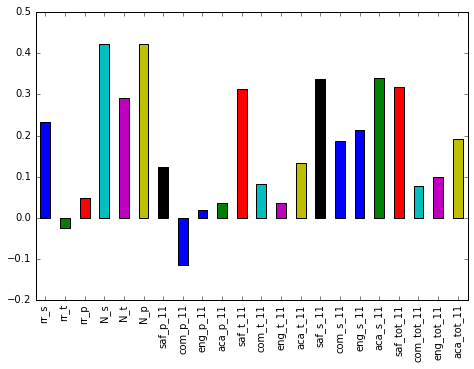

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

N_s = number of student respondents 
N_t = number of teacher respondents 
N_p = number of parent respondents 
saf_t_11 = Safety and Respect score based on teacher responses
saf_s_11 = Safety and Respect score based on student responses
aca_s_11 = Academic expectations score based on student responses
saf_tot_11 = Safety and Respect total score

These 7 columns seem to have the highest positive correlations with SAT score. The interesting columns are safety and respect scores having a positive correlation with SAT scores, which could suggest a more encouraging and safe learning environment for students leads to better performance. Also, student reported academic expectations has a relatively strong positive correlation with SAT score, meaning that the higher expectations a student perceives they have, the better they performed on the SAT. The only negative correlations are the communication score parent response and the teacher response rate. This suggests that perhaps less engaged educators leads to poorer performance.

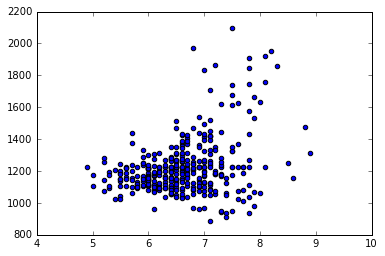

In [13]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.show()

From the scatterplot, we can see the positive correlation between safety score and the SAT score. We also observe that there is a large cluster of low to moderate safety scores with lower SAT scores. We can investigate this further by grouping by district and computing the average safety scores for each district.

In [14]:
district_means = combined.groupby('DBN').agg(numpy.mean)
district_means = district_means['saf_s_11']
combined['district_means'] = district_means

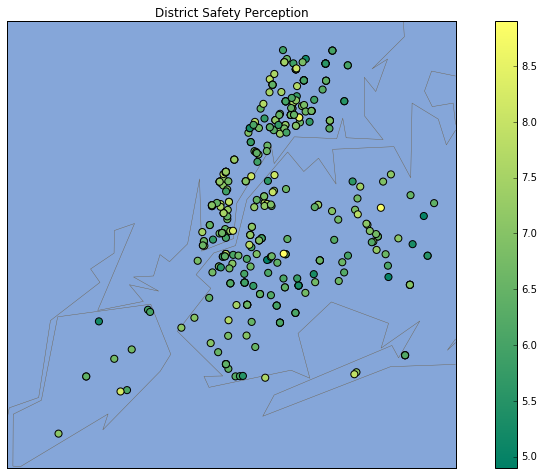

In [15]:
from mpl_toolkits.basemap import Basemap

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

plt.figure(figsize=(14,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=combined["saf_s_11"],cmap="summer")
plt.title("District Safety Perception")
plt.colorbar()
plt.show()

Looking at a map of the NYC boroughs, we can see that there is some difference in safety scores and borough. For instance, Staten Island appears to have overall good safety scores. Manhattan also looks like it has overall above average safety scores. The Bronx appears to have slightly worse safety scores. This seems to be in line with [crime statistics](https://maps.nyc.gov/crime/) for the city, with Manhattan being somewhat of an exception, but we can see that there are lower crime areas in Manhattan as well. From the crime statistics map, we can see that lower crime rate areas, in general, have higher safety scores from the survey.

![title](https://wp-tid.zillowstatic.com/streeteasy/2/NYCcrimemap-8351ee.png)

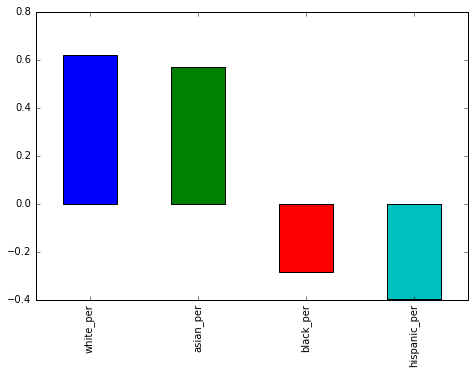

In [16]:
race_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
combined.corr()['sat_score'][race_per].plot.bar()
plt.show()

There appear to be strong positive correlations for white and asian percentages with SAT scores, but somewhat strong negative correlations for black and hispanic percentages. We will continue analysis to determine if there is more data to determine why. 

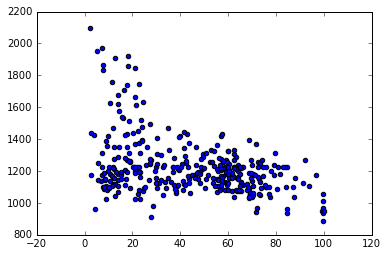

In [17]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.show()

We can see that all the schools that had an average SAT score above 1600 had small hispanic populations, and the schools with 100% hispanic populations performed around or under SAT scores of 1000. 

We will continue analysis to see why schools with high hispanic populations perform poorly on the SAT, and explore the demographic composition of schools with low hispanic populations and low SAT scores.

Here are the schools with hispanic population percentages greater than 95%. 

In [18]:
hispanic_95 = combined[combined['hispanic_per'] > 95]
print(hispanic_95['School Name'])

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


There are 5 school names that we can investigate. From some research on each of these schools, we can see that most of the students are English learners, meaning that English is not their first language. They are also all very small schools, with less than 1000 students attending each school. The chronically absent average was relatively high for each school, while still under the average from the city, it was pretty close to the average in each case. The sources for this information for each school is linked below. 

English Language Learners is actually a column in the dataset, which we should explore. 


[Manhattan Bridges High School](https://tools.nycenet.edu/snapshot/2019/02M542/HS/)

[Gregorio Luperon High School for Science and Mathematics](https://tools.nycenet.edu/snapshot/2019/06M552/HS/)

[International School for Liberal Arts](https://tools.nycenet.edu/snapshot/2019/10X342/HS/)

[Multicultural High School](https://tools.nycenet.edu/snapshot/2019/19K583/HS/)

[Pan American International High School](https://tools.nycenet.edu/snapshot/2019/24Q296/HS/)

In [19]:
hispanic_10 = combined[combined['hispanic_per'] < 10]
hispanic_10_sat = hispanic_10[hispanic_10['sat_score'] > 1800]
print(hispanic_10_sat['School Name'])

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


From some research on these schools, we can see that each one has a high percentage of Asian students, a small hispanic or black population, and 0% of the students are English learners. We can also see that the attendance average is well above the city average in each case, and that the chronically absent percentage is well below the city average. All but one of these schools has a larger total population, with each school having more than 1300 students, except Queens High School for the Sciences at York College, which has a smaller population of around 400 students. Much of this data is included in the dataset, and should be explored and visualized.


[Stuyvesant High School](https://tools.nycenet.edu/snapshot/2019/02M475/HS/)

[The Bronx High School of Science](https://tools.nycenet.edu/snapshot/2019/10X445/HS/)

[Brooklyn Technical High School](https://tools.nycenet.edu/snapshot/2019/13K430/HS/)

[Queens High School for the Sciences at York College](https://tools.nycenet.edu/snapshot/2019/28Q687/HS/)

[Staten Island Technical High School](https://tools.nycenet.edu/snapshot/2019/31R605/HS/)

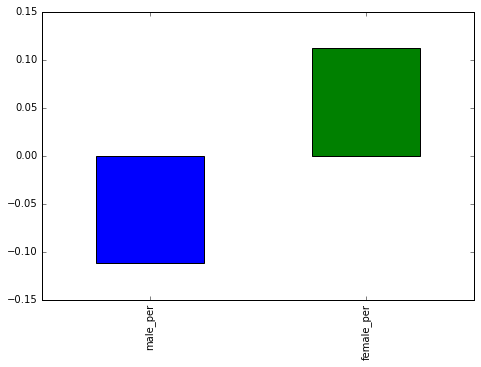

In [20]:
gender = ['male_per', 'female_per']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
combined.corr()['sat_score'][gender].plot.bar()
plt.show()

These are somewhat interesting correlations. While neither is a very strong correlation, it is interesting that having a higher female percentage of students has a positive correlation with SAT scores, while a higher male percentage of students has a negative correlation. 

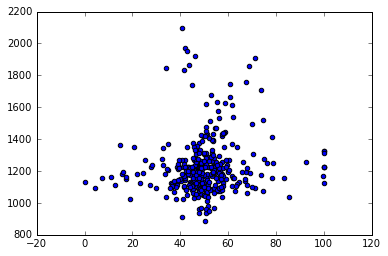

In [21]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.show()

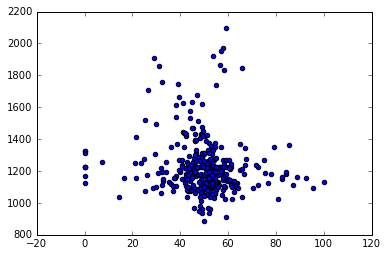

In [22]:
plt.scatter(combined['male_per'], combined['sat_score'])
plt.show()

From the scatterplots, we can actually see that having a more even split of male and female students can lead to higher SAT scores. It appears as though having an all-boys school or an all-girls school doesn't lead to higher SAT scores. 

In [23]:
female = combined[combined['female_per'] > 60]
female_sat = female[female['sat_score'] > 1700]
print(female_sat['School Name'])

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


The above school names are schools that have a higher than 60% female population, and an average SAT score above 1700. Each of these schools have higher percentages of white and asian populations, but also have relatively higher percentages of black and hispanic populations as well. They are all described as being academically rigorous, and some begin teaching college courses during 11th grade. The schools all have excellent attendance averages, and chronically absent averages well below the city average. Some of the schools have more specialized programs, such as a theater and arts focused curriculum, or a focus on technology and math. 

In [24]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

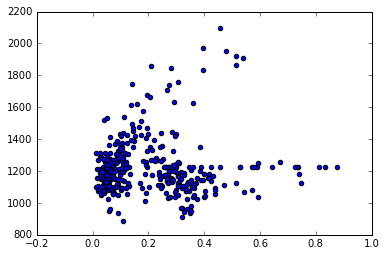

In [25]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.show()

This scatterplot illustrates the percentage of AP test takers for each higher school versus their average SAT score. There is some correlation between higher percentage of students who take AP classes and higher SAT score, but there are also plenty of schools with high percentages of AP students and lower SAT schools. This will require more investigation, such as looking at the number of passing AP scores per school. 

Because we imputing average scores for some missing values when preparing the data, we should remove these rows for an accurate analysis of AP scores, because a lot of the missing values were in this column. 

In [26]:
accurate_aps = combined[combined['Number of Exams with scores 3 4 or 5'] != 153.45]

accurate_aps['Passing AP Percentage'] = accurate_aps['Number of Exams with scores 3 4 or 5'] / accurate_aps.iloc[:,9]

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


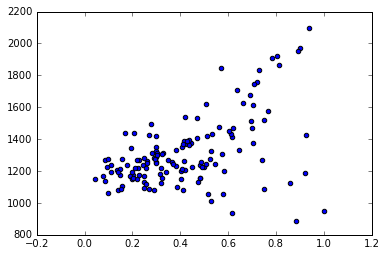

In [27]:
plt.scatter(accurate_aps['Passing AP Percentage'], accurate_aps['sat_score'])
plt.show()

I first added a column to compute the percentage of passing AP tests of the total number of AP tests taken per school. Then comparing this percentage with SAT scores, there is a clear positive correlation between passing AP scores and higher SAT scores. 

## Assigning Scores to Schools

Using some of the insights we have gained through exploring correlations in the data, we can create a system to assign scores to each school, based on different measures from the school and survey data to determine the highest performing schools. 

We can use the highest positive and negative correlation columns to SAT score to create a scoring system for each school. We can use: SAT score, AP test passing percentage (we can apply the average passing percentage to those rows missing values for this problem), female population percentage, safety scores, academic expectation scores, average class size, english language learners, and free and reduced lunch percentages to create a simple system to begin with. 

We can start by reducing our dataset to just these columns to simplify. 

In [28]:
# find average for AP passing scores to impute into missing values
avg_pass_ap = accurate_aps['Passing AP Percentage'].mean()

In [29]:
combined['Number of Exams with scores 3 4 or 5'] = combined['Number of Exams with scores 3 4 or 5'].replace(153.45, 0)
combined['Passed AP'] = combined['Number of Exams with scores 3 4 or 5'] / combined.iloc[:,9]
combined['Passed AP'] = combined['Passed AP'].replace(0.0, avg_pass_ap)

In [30]:
reduced = combined[['DBN', 'School Name', 'sat_score', 'female_per', 'AVERAGE CLASS SIZE', 'aca_s_11', 'saf_s_11', 'ell_percent', 'frl_percent', 'Passed AP']]
reduced.head()

,DBN,School Name,sat_score,female_per,AVERAGE CLASS SIZE,aca_s_11,saf_s_11,ell_percent,frl_percent,Passed AP
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,1122.0,38.6,22.564286,6.700000,6.000000,22.3,88.6,0.418363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,1172.0,42.6,22.231250,7.000000,6.000000,21.1,71.8,0.204082
2,01M450,EAST SIDE COMMUNITY SCHOOL,1149.0,45.3,21.200000,7.381389,6.611667,5.0,71.8,0.418363
3,01M509,MARTA VALLE HIGH SCHOOL,1207.0,53.7,23.571429,7.000000,6.400000,11.2,80.7,0.418363
4,01M539,NEW EXPLORATIONS INTO SCIENCE TECHNO,1621.0,50.8,25.510526,7.700000,7.300000,0.2,23.0,0.506631


We can now take the averages for each column to use some of that information for scoring. 

In [31]:
scoring_averages = reduced.mean()
scoring_averages

sat_score             1223.438806
female_per              50.620661
AVERAGE CLASS SIZE      24.794077
aca_s_11                 7.381389
saf_s_11                 6.611667
ell_percent             13.334986
frl_percent             66.119008
Passed AP                0.418363
dtype: float64

We will have to have different criteria for each part of the score. For instance, we can normalize the SAT scores by dividing each score by the 2400 total possible points. For female percentage, we can give a higher score for having a more balanced population, since we saw previously that having a more balanced student population in terms of gender led to higher performance. We can then multiply each column's score by it's correlation to SAT score, sum the score, and find the best overall schools. 

In [32]:
reduced['sat_score_percent'] = reduced['sat_score'] / 2400
reduced_corrs = reduced.corr()
reduced_corrs_sat = reduced_corrs['sat_score']
print(reduced_corrs_sat)

sat_score             1.000000
female_per            0.112108
AVERAGE CLASS SIZE    0.381014
aca_s_11              0.339435
saf_s_11              0.337639
ell_percent          -0.398750
frl_percent          -0.722225
Passed AP             0.376893
sat_score_percent     1.000000
Name: sat_score, dtype: float64


/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
corr_scores = ['female_per_corr', 'avg_class_size_corr', 'aca_s_11_corr', 'saf_s_11_corr', 'ell_percent_corr', 'frl_percent_corr', 'passed_ap_corr', 'sat_score_percent_corr']
cols = reduced.columns
j = 2
for i in corr_scores:
    reduced[i] = reduced[cols[j]] * reduced_corrs_sat[j-1]
    j+=1
reduced['sum_score']= reduced.iloc[:, 10:-1].sum(axis=1)
reduced.head()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DBN,School Name,sat_score,female_per,AVERAGE CLASS SIZE,aca_s_11,saf_s_11,ell_percent,frl_percent,Passed AP,sat_score_percent,female_per_corr,avg_class_size_corr,aca_s_11_corr,saf_s_11_corr,ell_percent_corr,frl_percent_corr,passed_ap_corr,sat_score_percent_corr,sum_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,1122.0,38.6,22.564286,6.700000,6.000000,22.3,88.6,0.418363,0.467500,125.784884,14.707153,7.659119,2.262180,-2.392498,-16.105609,33.392759,0.418363,165.775486
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,1172.0,42.6,22.231250,7.000000,6.000000,21.1,71.8,0.204082,0.488333,131.390271,16.231210,7.546075,2.363471,-2.392498,-15.238940,27.060949,0.204082,167.448871
2,01M450,EAST SIDE COMMUNITY SCHOOL,1149.0,45.3,21.200000,7.381389,6.611667,5.0,71.8,0.418363,0.478750,128.811793,17.259949,7.196032,2.492243,-2.636400,-3.611123,27.060949,0.418363,177.052192
3,01M509,MARTA VALLE HIGH SCHOOL,1207.0,53.7,23.571429,7.000000,6.400000,11.2,80.7,0.418363,0.502917,135.314041,20.460470,8.000979,2.363471,-2.551998,-8.088916,30.415300,0.418363,186.416264
4,01M539,NEW EXPLORATIONS INTO SCIENCE TECHNO,1621.0,50.8,25.510526,7.700000,7.300000,0.2,23.0,0.506631,0.675417,181.726646,19.355528,8.659178,2.599818,-2.910873,-0.144445,8.668549,0.506631,218.629817


In [35]:
scores = reduced[['School Name', 'sat_score', 'sum_score']]
scores.sort_values('sum_score', ascending=False)

,School Name,sat_score,sum_score
37,STUYVESANT HIGH SCHOOL,2096.000000,273.016835
302,TOWNSEND HARRIS HIGH SCHOOL,1910.000000,262.608323
151,BRONX HIGH SCHOOL OF SCIENCE,1969.000000,260.889331
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.000000,252.122225
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.000000,251.972190
155,HIGH SCHOOL OF AMERICAN STUDIES AT LE,1920.000000,248.694820
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.000000,248.475640
327,QUEENS HIGH SCHOOL FOR THE SCIENCES A,1868.000000,244.897674
198,BROOKLYN LATIN SCHOOL THE,1740.000000,240.449027
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF,1707.000000,238.517342


These rankings are pretty in line with SAT scores, and we may be putting too much weight on SAT scores. More analysis is required, but for now this seems like a good ranking of public schools in New York City. According to Niche.com, our top 5 ranking is pretty much spot on. 

[Stuyvesant High School: ranked 1 in New York Public Schools](https://www.niche.com/k12/stuyvesant-high-school-new-york-ny/)

[Townsend Harris High School: ranked 3 in New York Public Schools](https://www.niche.com/k12/townsend-harris-high-school-flushing-ny/)

[Bronx High School of Science: ranked 4 in New York Public Schools](https://www.niche.com/k12/bronx-high-school-of-science-bronx-ny/)

[Staten Island Technical High School: ranked 2 in New York Public Schools](https://www.niche.com/k12/staten-island-technical-high-school-staten-island-ny/)

[Brooklyn Technical High School: ranked 2 in Standout New York High Schools](https://www.niche.com/k12/brooklyn-technical-high-school-brooklyn-ny/)

### Data Sources 


[SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)


[School Attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)


[Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)


[AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)


[Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)


[Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)


[School Surveys](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

Next steps:

- determine if the scoring system relies too heavily on SAT score and how it can be improved 
- figuring out which neighborhoods have the best schools
    - if we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good school
- more analysis on survey data